In [1]:
import s2sphere
from itertools import combinations
from itertools import chain
import shapefile
import numpy as np
from shapely.geometry import Polygon, Point, shape
from rasterstats import zonal_stats, point_query
import pandas as pd
import s2sphere
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

/Users/qianzh/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def find_1_neighbour(cell_id_str):
    new_cellid =s2sphere.CellId.from_token(cell_id_str)
    sxzy = new_cellid.get_edge_neighbors()
    comb = combinations(sxzy,2)
    corner = []
    for i in comb:
        common = list(set(i[0].get_edge_neighbors()).intersection(i[1].get_edge_neighbors()))
        corner.append(common)
    corner = list(chain(*corner))
    corner = list(filter(lambda a: a != new_cellid, corner))
    first_neighbor = list(sxzy) + corner
    return(first_neighbor)

In [3]:
def find_2_neighbour(first_neighbor, cell_id_str):
    new_cellid =s2sphere.CellId.from_token(cell_id_str)
    first_sxzy = []
    for cellid in first_neighbor:
        first_sxzy = first_sxzy + list(cellid.get_edge_neighbors())
    first_sxzy = list(set(first_sxzy) - set(first_neighbor))
    first_sxzy = list(filter(lambda a: a != new_cellid, first_sxzy))
    comb_2 = combinations(first_sxzy,2)
    corner_2 = []
    for i in comb_2:
        common = list(set(i[0].get_edge_neighbors()).intersection(i[1].get_edge_neighbors()))
        corner_2.append(common)
    corner_2 = list(chain(*corner_2))
    corner_2 = list(set(corner_2)- set(first_neighbor)- set(first_sxzy))
    second_neighbor = first_sxzy + corner_2
    return(second_neighbor)

In [4]:
def s2_cov(cell_list, rasterfile):
    values  =  []
    for ids in cell_list[:]:
        new_cell = s2sphere.Cell(s2sphere.CellId.from_token(str(ids)))
        vertices = []
        for i in range(0, 4):
            vertex = new_cell.get_vertex(i)
            latlng = s2sphere.LatLng.from_point(vertex)
            vertices.append((latlng.lng().degrees,latlng.lat().degrees))
        geo = Polygon(vertices)
        point_est = point_query(geo.centroid, rasterfile)
        values = values + point_est
    return values

In [5]:
def pop_w_neighbor(id_list, pop_raster):
    pop = 0
    new_id = []
    for cellid in id_list:
        sid = str(cellid)[8:15]
        new_id.append(sid)
    pop = s2_cov(new_id, pop_raster)
    return(pop)

In [24]:
def neighbour_pop_prob(idlist, pop_raster, travel_cell_file):
    country_cell = pd.read_csv(travel_cell_file)
    country_cell['exp_move'] = np.exp(country_cell['move_raw'])
    home_pop = s2_cov(idlist, pop_raster)
    first_pop_sum = []
    second_pop_sum = []
    home_travel = []
    first_travel = []
    second_travel = []
    home_move = []
    first_move = []
    second_move = []
    for cell in idlist:
        first_neighbour = find_1_neighbour(cell)
        second_neighbour = find_2_neighbour(first_neighbour, cell)
        first_ngb_pop = pop_w_neighbor(first_neighbour, pop_raster)
        second_ngb_pop = pop_w_neighbor(second_neighbour, pop_raster)
        first_ngb_pop = pd.Series(first_ngb_pop, dtype=object).fillna(0).tolist()
        second_ngb_pop = pd.Series(second_ngb_pop, dtype=object).fillna(0).tolist()
        first_pop_sum.append(sum(first_ngb_pop))
        second_pop_sum.append(sum(second_ngb_pop))
        first_new_id = []
        for cellid in first_neighbour:
            sid = str(cellid)[8:15]
            first_new_id.append(sid)
        second_new_id = []
        for cellid in second_neighbour:
            sid = str(cellid)[8:15]
            second_new_id.append(sid)
        total_cell = country_cell.loc[country_cell['origin_s2'] == cell]
        if total_cell.shape[0] == 0:
            home_travel.append(0)
            first_travel.append(0)
            second_travel.append(0)
        else:
            home_cell = total_cell.loc[total_cell['dest_s2'] == cell]
            first_cell = total_cell[total_cell['dest_s2'].isin(first_new_id)]
            second_cell = total_cell[total_cell['dest_s2'].isin(second_new_id)]
            home_move.append(np.sum(home_cell['exp_move']))
            first_move.append(np.sum(first_cell['exp_move']))
            second_move.append(np.sum(second_cell['exp_move']))
            home_travel.append(home_cell.shape[0]/total_cell.shape[0])
            first_travel.append(first_cell.shape[0]/total_cell.shape[0])
            second_travel.append(second_cell.shape[0]/total_cell.shape[0])
        
    results = pd.DataFrame({'home_pop':home_pop,'first_pop_sum':first_pop_sum, 'second_pop_sum':second_pop_sum, 'home_travel':home_travel,
                           'first_travel':first_travel, 'second_travel':second_travel, 'home_move': home_move, 
                           'first_move': first_move, 'second_move':second_move})
    return(results)

In [20]:
def scatter_plot_with_correlation_line(x, y, graph_filepath):
    '''
    http://stackoverflow.com/a/34571821/395857
    x does not have to be ordered.
    '''
    # Scatter plot
    plt.scatter(x, y)

    # Add correlation line
    axes = plt.gca()
    m, b = np.polyfit(x, y, 1)
    X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
    plt.plot(X_plot, m*X_plot + b, '-')

    # Save figure
    plt.savefig(graph_filepath, dpi=300, format='png', bbox_inches='tight')

In [21]:
pop_raster = "/Users/qianzh/project/human_mobility/data/covariates/population/worldpop_total_1y_2016_00_00.tif"

In [25]:
mozambique = pd.read_csv("/Users/qianzh/project/TaR/trial/mozambique/movement_home_in_Mozambique.csv")
cell_file = "/Users/qianzh/project/TaR/trial/mozambique/travel_international_170.csv"
mozambique_pop = neighbour_pop_prob(mozambique['s2_id'], pop_raster, cell_file )
mozambique_pop['s2_id'] = mozambique['s2_id']


/Users/qianzh/anaconda3/lib/python3.5/site-packages/rasterstats/point.py:167: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, nodata=nodata, affine=affine, band=band) as rast:
/Users/qianzh/anaconda3/lib/python3.5/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)


In [26]:
mozambique_pop

,first_move,first_pop_sum,first_travel,home_move,home_pop,home_travel,second_move,second_pop_sum,second_travel,s2_id
0,1.117680e-04,1.083717e+06,0.063492,4.585621e-05,143791.181625,0.007937,6.006643e-05,1.743266e+06,0.111111,1ee6907
1,1.869393e-04,1.120151e+06,0.055556,7.948041e-05,158948.658590,0.006944,9.843008e-05,1.674729e+06,0.083333,1ee69a9
2,1.335556e-05,4.237631e+05,0.217391,5.395205e-06,89770.335971,0.043478,3.080012e-06,2.346838e+05,0.217391,18bfc9b
3,2.248301e-05,1.075266e+06,0.166667,5.962623e-06,191146.160937,0.027778,8.304646e-06,9.790274e+05,0.194444,18c6351
4,0.000000e+00,7.025900e+03,0.000000,1.629211e-07,1356.854349,1.000000,0.000000e+00,8.480635e+03,0.000000,18c0057
5,0.000000e+00,4.152533e+03,0.000000,1.712742e-07,591.518112,1.000000,0.000000e+00,7.001787e+03,0.000000,18c00cf
6,2.454924e-07,1.004321e+04,0.500000,2.795737e-07,989.224082,0.500000,0.000000e+00,2.381587e+04,0.000000,18c1f59
7,2.382370e-07,9.505214e+03,0.250000,4.170749e-07,739.409339,0.250000,0.000000e+00,2.571796e+04,0.000000,18c21e3
8,1.931111e-07,2.653374e+04,0.500000,2.288956e-07,4838.712563,0.500000,0.000000e+00,2.992281e+04,0.000000,18c218d
9,3.473803e-07,2.359443e+04,0.500000,4.088163e-07,3394.464830,0.250000,0.000000e+00,3.127432e+04,0.000000,18c21f3


/Users/qianzh/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()


Text(0.5,1,'Proportion of staying at home with population counts in one cell ')

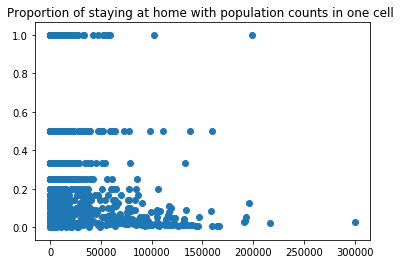

In [28]:
Y = mozambique_pop['home_travel']
X = mozambique_pop['home_pop']
scatter_plot_with_correlation_line(X, Y, "/Users/qianzh/project/TaR/trial/mozambique_home.png")
plt.title("Proportion of staying at home with population counts in one cell ")

Text(0.5,1,'In one cell: population vs. relative movement')

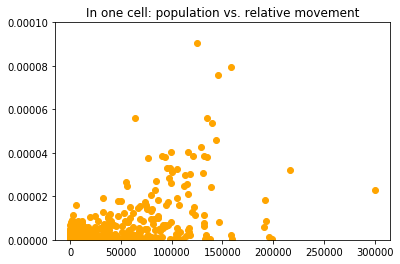

In [62]:
plt.scatter(X,mozambique_pop['home_move'], color = 'orange')
plt.ylim(0,0.0001)
plt.title("In one cell: population vs. relative movement")

/Users/qianzh/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()


Text(0.5,1,'Proportion of staying at home with population counts in 3x3 cells ')

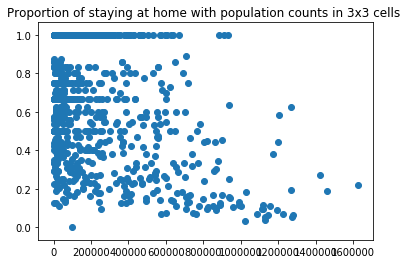

In [30]:
Y1 = mozambique_pop['home_travel'] + mozambique_pop['first_travel']
X1 = mozambique_pop['home_pop'] + mozambique_pop['first_pop_sum']
scatter_plot_with_correlation_line(X1, Y1, "/Users/qianzh/project/TaR/trial/mozambique_first.png")
plt.title("Proportion of staying at home with population counts in 3x3 cells ")

Text(0.5,1,'In 3x3 cell: population vs. relative movement')

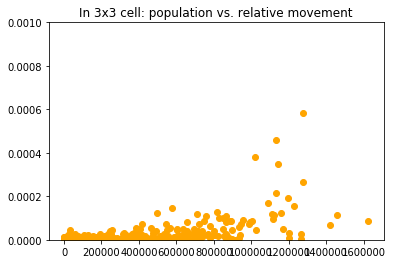

In [63]:
plt.scatter(X1,(mozambique_pop['home_move'] + mozambique_pop['first_move']), color = 'orange')
plt.ylim(0,0.001)
plt.title("In 3x3 cell: population vs. relative movement")

/Users/qianzh/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()


Text(0.5,1,'Proportion of staying at home with population counts in 5x5 cells ')

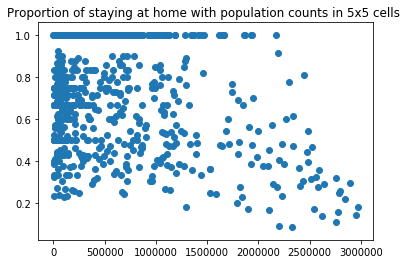

In [31]:
Y2 = mozambique_pop['home_travel']+ mozambique_pop['first_travel'] + mozambique_pop['second_travel']
X2 = mozambique_pop['home_pop'] + mozambique_pop['first_pop_sum'] + mozambique_pop['second_pop_sum']
scatter_plot_with_correlation_line(X2, Y2, "/Users/qianzh/project/TaR/trial/mozambique_second.png")
plt.title("Proportion of staying at home with population counts in 5x5 cells ")

Text(0.5,1,'In 5x5 cell: population vs. relative movement')

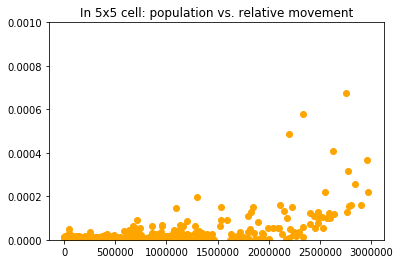

In [64]:
plt.scatter(X2,(mozambique_pop['home_move'] + mozambique_pop['first_move'] + mozambique_pop['second_move']), color = 'orange')
plt.ylim(0,0.001)
plt.title("In 5x5 cell: population vs. relative movement")

/Users/qianzh/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()


Text(0.5,1,'Proportion of staying at home with log(population counts) in one cell ')

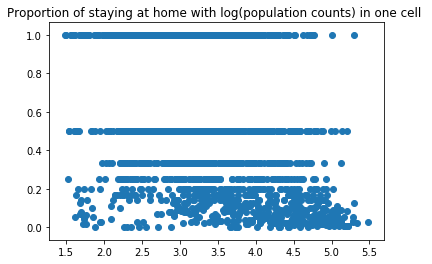

In [33]:
Y_log = mozambique_pop['home_travel']
X_log = np.log10(mozambique_pop['home_pop'])
scatter_plot_with_correlation_line(X_log, Y_log, "/Users/qianzh/project/TaR/trial/mozambique_home_log.png")
plt.title("Proportion of staying at home with log(population counts) in one cell ")

Text(0.5,1,'In one cell: log_population vs. relative movement')

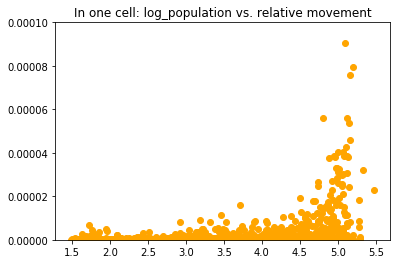

In [55]:
plt.scatter(X_log,(mozambique_pop['home_move']), color = 'orange')
plt.ylim(0,0.0001)
plt.title("In one cell: log_population vs. relative movement")

/Users/qianzh/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()


Text(0.5,1,'Proportion of staying at home with log(population counts) in 3x3 cells ')

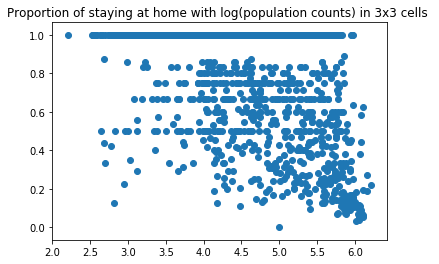

In [34]:
Y1 = mozambique_pop['home_travel'] + mozambique_pop['first_travel']
X1_log = np.log10(mozambique_pop['home_pop'] + mozambique_pop['first_pop_sum'])
scatter_plot_with_correlation_line(X1_log, Y1, "/Users/qianzh/project/TaR/trial/mozambique_first_log.png")
plt.title("Proportion of staying at home with log(population counts) in 3x3 cells ")

Text(0.5,1,'In 3x3 cell: log_population vs. relative movement')

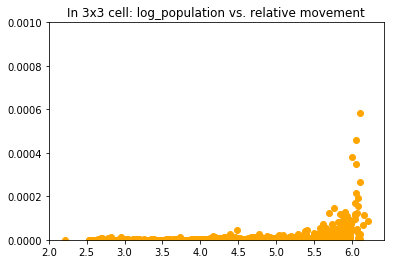

In [59]:
plt.scatter(X1_log,(mozambique_pop['home_move'] + mozambique_pop['first_move']), color = 'orange')
plt.ylim(0,0.001)
plt.title("In 3x3 cell: log_population vs. relative movement")

/Users/qianzh/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()


Text(0.5,1,'Proportion of staying at home with log(population counts) in 5x5 cells ')

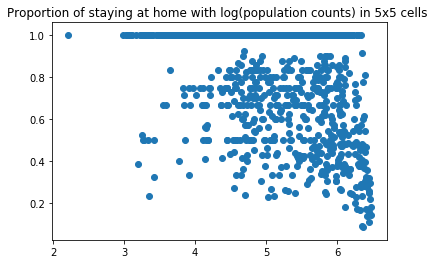

In [65]:
Y2 = mozambique_pop['home_travel']+ mozambique_pop['first_travel'] + mozambique_pop['second_travel']
X2_log = np.log10(mozambique_pop['home_pop'] + mozambique_pop['first_pop_sum'] + mozambique_pop['second_pop_sum'])
scatter_plot_with_correlation_line(X2_log, Y2, "/Users/qianzh/project/TaR/trial/mozambique_second_log.png")
plt.title("Proportion of staying at home with log(population counts) in 5x5 cells ")

Text(0.5,1,'In 5x5 cell: log_population vs. relative movement')

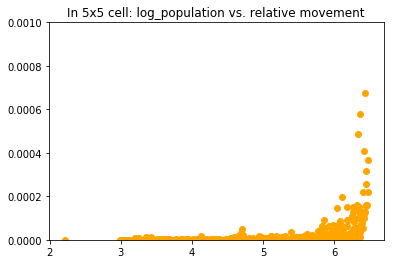

In [66]:
plt.scatter(X2_log,(mozambique_pop['home_move']+ mozambique_pop['first_move'] + mozambique_pop['second_move']), color = 'orange')
plt.ylim(0,0.001)
plt.title("In 5x5 cell: log_population vs. relative movement")